## Continous time Quantum Monte Carlo of a single spin

The Hamiltonian of a single spin in a magnetic field is
$$
H = h \sigma_z + \Gamma \sigma_x.
$$
The analytical solution for the magnetization $\langle \sigma_x \rangle$ is
$$
\langle \sigma_x \rangle = \frac{\Gamma}{\sqrt{\Gamma^2+h^2}} \tanh\left( \beta \sqrt{h^2+\Gamma^2} \right).
$$
We map the quantum system to a classical continous 1D spin chain of length $\beta$. The total energy of the system is
$$
E_\mathrm{tot} = h \int_0^1 \mathop{d\tau} S_z(\beta\tau) - \frac{1}{2} \log(\mathop{d\tau} \Gamma)\, n,
$$
wher $n$ is the number of domain walls and $S_z(\tau)$ is the magnetization. From the above result we can calculate the acceptance probabilities
$$
p_\mathrm{acc.} = \min\left( 1, \frac{\pi(Y)\, T(Y\rightarrow X)}{\pi(X)\, T(X\rightarrow Y)} \right).
$$
For adding a domain wall we get
$$
\frac{\pi(Y)}{\pi(X)} = \exp({-\beta \Delta E}) = \mathop{d\tau}\Gamma \exp({-\beta h \mathop{\Delta S_z^\mathrm{tot}}}),\ T(Y\rightarrow X)=\frac{1}{n+1}\ \mathrm{and}\ T(X\rightarrow Y)=\frac{\mathop{d\tau}}{\beta}.
$$
Therefore, the acceptance probability for adding two domain walls is
$$
p_\mathrm{acc.}^\mathrm{add} = \min\left( 1, \frac{\exp(-\beta h \mathop{\Delta S_z^\mathrm{tot}}) (\Gamma \beta)^2}{(n+1)(n+2)} \right) ,
$$
and for removing two domain walls it is
$$
p_\mathrm{acc.}^\mathrm{rem.} = \min\left( 1, \frac{\exp(-\beta h \mathop{\Delta S_z^\mathrm{tot}})n(n+1)}{ (\Gamma \beta)^2} \right) ,
$$

In [133]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import copy
from sys import stdout
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

### Analytical solution

In [134]:
sx = lambda gamma,h,beta: gamma/np.sqrt(gamma**2+h**2)*np.tanh(beta*np.sqrt(h**2+gamma**2))

### Worldline class for simulation

In [135]:
class Worldline:
    def __init__(self,beta,gamma,h=0):
        self.beta  = beta  # inverse temperature \beta
        self.gamma = gamma # transverse field \Gamma
        self.h     = h # magnetic field h
        self.s0    = 1  # spin at \tau=0
        self.kinks = [] # position of kinks (domain walls), sorted from 0 to beta
        self.magnobs = []
        
    def sz(self,kinks,s0):
        if len(kinks)>0:
            sz = s0 * (self.beta-kinks[-1]+kinks[0])
            for i in range(len(kinks)-1):
                sz += s0*(-1)**(i+1)*(kinks[i+1]-kinks[i])
        else:
            sz = self.beta*s0
        return sz
        
    def szdifference_add(self,ta,tb):
        if ta > tb:
            ns0 = -1*self.s0
        else:
            ns0 = self.s0
        nkinks = copy.deepcopy(self.kinks)
        nkinks += (ta,tb)
        nkinks.sort()
        return self.sz(nkinks,ns0)-self.sz(self.kinks,self.s0)
        
    def szdifference_rem(self,i,j):
        nkinks = copy.deepcopy(self.kinks)
        if i > j:
            del nkinks[i]
            del nkinks[j]
            ns0 = -1*self.s0
        else:
            del nkinks[j]
            del nkinks[i]
            ns0 = self.s0
        return self.sz(nkinks,ns0)-self.sz(self.kinks,self.s0)
    
    def insertUpdate(self):
        # propose to add kinks at times ta, tb, flipping all spins in range (ta,tb)
        ta = rnd.uniform(0,self.beta)
        tb = rnd.uniform(0,self.beta)
        n = len(self.kinks)
        # acceptance ratio
        if abs(self.h) > 0:
            exp_h_dsz = np.exp(self.h*self.szdifference_add(ta,tb))
        else:
            exp_h_dsz = 1.
        pacc = exp_h_dsz*(self.beta*self.gamma)**2 / ((n+1.) * (n+2.))
        if pacc >= 1 or rnd.uniform(0,1) < pacc:
            self.kinks += (ta,tb)
            self.kinks.sort()
            if ta > tb: 
                self.s0 *= -1
    
    def removeUpdate(self):
        if len(self.kinks) == 0:
            return
        # propose to remove i'th and j'th kink
        i = j = rnd.randint(0,len(self.kinks))
        while j == i:
            j = rnd.randint(0,len(self.kinks))
        n = len(self.kinks)
        if abs(self.h) > 0:
            exp_h_dsz = np.exp(self.h*self.szdifference_rem(i,j))
        else:
            exp_h_dsz = 1.
        pacc = exp_h_dsz*n*(n-1.) / (self.beta*self.gamma)**2
        if pacc >= 1 or rnd.uniform(0,1) < pacc:
            if i > j:
                del self.kinks[i]
                del self.kinks[j]
                self.s0 *= -1
            else:
                del self.kinks[j]
                del self.kinks[i]
    
    def update(self):
        if rnd.uniform(0,1) < .5:
            self.insertUpdate()
        else:
            self.removeUpdate()
    
    def measure(self):
        self.magnobs.append(len(self.kinks) / (self.beta*self.gamma))

### Binning analysis

In [136]:
def binning_analysis(samples):
    """Perform a binning analysis over samples and return an array of the error estimate at each binning level."""
    minbins = 2**7 # minimum number of bins (128 still seems to be a reasonable sample size in most cases)
    maxlevel = int(np.log2(len(samples)//minbins))
    maxsamples = minbins * 2**(maxlevel)
    bins = np.array(samples[-maxsamples:]) # clip to power of 2 for simplicity
    errors = np.zeros(maxlevel+1)
    for k in range(maxlevel+1):
        errors[k] = np.std(bins)/np.sqrt(len(bins)-1.)
        bins = np.array([(bins[2*i]+bins[2*i+1])/2. for i in range(len(bins)//2)])
    return errors

### Main part

Gamma = 0.05000 , <sigma_x> = 0.04080 +- 0.01025 , tau =  2.72404
Gamma = 0.11020 , <sigma_x> = 0.08893 +- 0.00966 , tau =  2.39282
Gamma = 0.17041 , <sigma_x> = 0.12030 +- 0.01061 , tau =  3.49708
Gamma = 0.23061 , <sigma_x> = 0.16912 +- 0.00989 , tau =  2.84776
Gamma = 0.29082 , <sigma_x> = 0.23623 +- 0.01186 , tau =  3.95704
Gamma = 0.35102 , <sigma_x> = 0.25246 +- 0.01051 , tau =  3.42210
Gamma = 0.41122 , <sigma_x> = 0.30353 +- 0.00946 , tau =  2.64533
Gamma = 0.47143 , <sigma_x> = 0.34983 +- 0.00977 , tau =  2.85520
Gamma = 0.53163 , <sigma_x> = 0.39388 +- 0.00920 , tau =  2.53919
Gamma = 0.59184 , <sigma_x> = 0.41805 +- 0.01037 , tau =  3.62068
Gamma = 0.65204 , <sigma_x> = 0.45316 +- 0.00884 , tau =  2.59253
Gamma = 0.71224 , <sigma_x> = 0.49955 +- 0.00921 , tau =  2.82594
Gamma = 0.77245 , <sigma_x> = 0.50854 +- 0.00892 , tau =  2.87971
Gamma = 0.83265 , <sigma_x> = 0.56300 +- 0.00968 , tau =  3.50656
Gamma = 0.89286 , <sigma_x> = 0.57754 +- 0.00836 , tau =  2.62887
Gamma = 0.

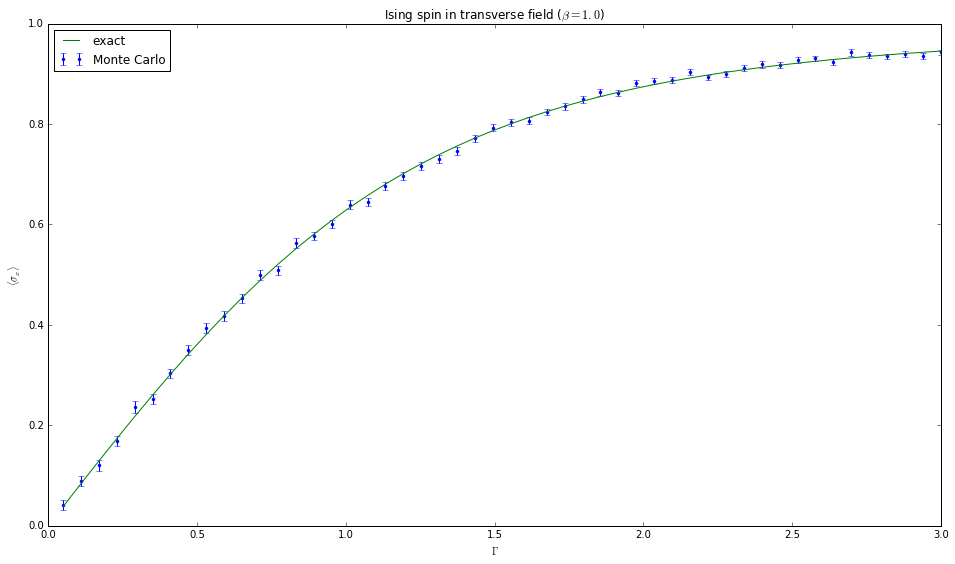

In [137]:
steps = int(1e5)
thermsteps = steps//5
beta = 1.
h = 1.
results = []
for gamma in np.linspace(0.05,3.,50):
    wl = Worldline(beta,gamma,h)
    for i in range(thermsteps):    wl.update()
    for i in range(steps):
        wl.update()
        wl.measure()
    mean = np.mean(wl.magnobs)
    errors = binning_analysis(wl.magnobs)
    tau = 0.5*(errors[-1]**2/np.std(wl.magnobs)**2*(len(wl.magnobs)-1.)-1.)
    print('Gamma =',"{:06.5f}".format(gamma), ', <sigma_x> =',"{:06.5f}".format(mean), '+-', '{:06.5f}'.format(errors[-1]), ", tau = ",'{:06.5f}'.format(tau))
    results.append([gamma, mean, errors[-1], tau])

results = np.transpose(np.array(results))
plt.figure()
plt.errorbar(results[0],results[1],results[2],fmt='.',label='Monte Carlo')
plt.plot(results[0],sx(results[0],h,beta),label='exact')
plt.xlabel('$\\Gamma$')
plt.ylabel('$\\langle \\sigma_x \\rangle$')
plt.title('Ising spin in transverse field ($\\beta='+str(beta)+'$)')
plt.legend(loc='best')
plt.show()